## References
- [Keras neural_style_transfer example](https://github.com/fchollet/keras/blob/master/examples/neural_style_transfer.py)
- [AI Artist](https://github.com/llSourcell/AI_Artist/blob/master/Network.py)

## Discussions
- [how to load pretrained weights](https://github.com/fchollet/keras/issues/3340)
- and [other parameters](https://github.com/fchollet/keras/pull/3347)

## Dependency
- needs [vgg16 model weights](https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing
(source: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)

## Idea
1. ***Images***: three images
    - result image: the image to be generated
    - style image: image contributing style (will talk about that in details later) to the result
    - content image: image contributing content to the result
2. ***Objectives***: three images will be represnted as variables, and the result image will be generated by optimizing a combination of objective functions, i.e.,
    - style loss: measures how different the styles of result and style image are. The style difference is measured by the inner-product distribution of different vgg filters (Gram matrix).
    - content loss: difference of features of generated and content images. The features are from different layers of vgg16
    - total variation loss: norm of horizontal and vertical gradient of generated images
3. ***Representations***: above loss functions depend on representations of images. Raw pixel may not be good enough to caputre "styles", "similarities" and etc. So the objectives will be based on features from a image network, namely vgg16.

In [1]:
%matplotlib inline

In [2]:
import keras
keras.__version__

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 980M (CNMeM is disabled, cuDNN 5005)


'1.0.6'

In [3]:
#from scipy.misc import imread, imresize, imsave
## use skimage imread because we want to read image from URL
## otherwise you can just use scipy.misc.imread/imresize/imwrite for local images
from skimage.io import imread, imsave
from skimage import img_as_ubyte, img_as_float
from skimage.transform import resize
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

In [4]:
from keras import backend as K

## load content_image, style_image
- style image is from Chinese painting

In [5]:
style_image = imread("http://www.artisoo.com/images/landscape/cnag220349.jpg")
content_image = imread("http://jrforasteros.com/wp-content/uploads/2010/02/Mountain-Tree.jpg")

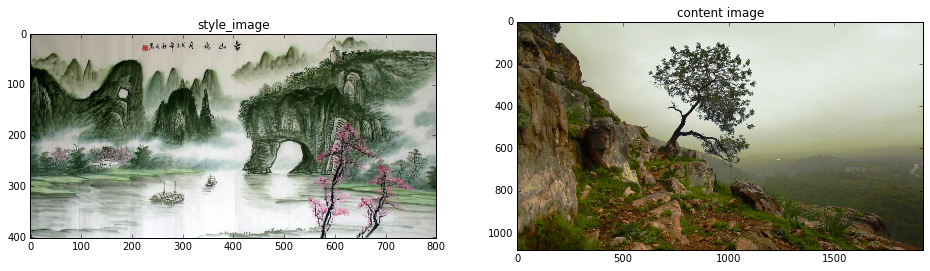

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
fig.subplots_adjust(wspace = 0.2, hspace = 0)
axes[0].imshow(style_image)
axes[0].set_title("style_image")
axes[1].imshow(content_image)
axes[1].set_title("content image")

## encode and decode images
- for images to be used by vgg16, it needs to be encoded, including
    - make sure the color channel is BGR
    - transpose image repr from (width, height, ncolors) to (ncolors, width, height) - this is the theano format that was used to train the vgg16 in the first place
    - extend the dimension to make images (or a single image) a batch of images of shape (nimages, nchannels, width, height). This is the format accepted by vgg16 and keras image models in general
    - resize image width and height to be equal - needed by Gram matrix in definition of objective function
    - substract each color channel for vgg16, see [discussion](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)
    ```python
    im[:,:,0] -= 103.939 # G channel
    im[:,:,1] -= 116.779 # B
    im[:,:,2] -= 123.68 # R
    ```
    - use float64 because later the l-bfgs-m optimizer needs this type

In [7]:
def encode(img, img_width = 400, img_height = 400):
    ## resize images
    assert img_width == img_height, "square image required by Gram matrix"
    img = resize(img, (img_width, img_height))
    ## convert to ubyte to make sure pixel range in 0 to 255
    img = img_as_ubyte(img).astype("float64")
    ## RGB to BGR
    img = img[:, :, ::-1]
    ## mean centerization
    img[:,:,0] -= 103.939
    img[:,:,1] -= 116.779
    img[:,:,2] -= 123.68
    ## theano format: (color, width, height)
    img = img.transpose((2, 0, 1))
    ## make it a single element batch
    img = np.expand_dims(img, axis = 0)
    return img

def decode(img):
    ## (color, w, h) => (w, h, color)
    img = img.transpose((1, 2, 0))
    img[:,:,0] += 103.939
    img[:,:,1] += 116.779
    img[:,:,2] += 123.68
    ## BGR to RGB
    img = img[:, :, ::-1]
    ## make sure pixel range in 0 to 255
    img = np.clip(img, 0, 255.).astype(np.ubyte)
    return img

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


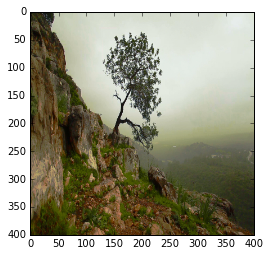

In [8]:
encoded_content_img = encode(content_image)
decoded_content_img = decode(encoded_content_img[0])
plt.imshow(decoded_content_img)

## Load vgg16 models and weights
- features from intermediate layers of vgg16 will be used in defining content_loss, sytle_loss later
- the challenge here is
    - we need to change parts of vgg16, including the shape of the first padding layer, and poping out the last fewer fully connected layers
    - however, the pre-trained weights are defined "exactly" for the original vgg16 model
    - several methods can be used, explictly and partially load the weight hdf5 file might be the most straightforward way - it works because padding layers dont actually have weights

In [9]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
import h5py

In [15]:
## keras h5 weights are organized as 
## - first level group: layers, with attrs nb_layers
## - second level group: params, with attrs nb_params
## weight["layer_i/parma_j"] define the real weight matrix
weights = h5py.File("../data/vgg16_keras/vgg16_weights.h5")
print weights.keys()

[u'layer_0', u'layer_1', u'layer_10', u'layer_11', u'layer_12', u'layer_13', u'layer_14', u'layer_15', u'layer_16', u'layer_17', u'layer_18', u'layer_19', u'layer_2', u'layer_20', u'layer_21', u'layer_22', u'layer_23', u'layer_24', u'layer_25', u'layer_26', u'layer_27', u'layer_28', u'layer_29', u'layer_3', u'layer_30', u'layer_31', u'layer_32', u'layer_33', u'layer_34', u'layer_35', u'layer_36', u'layer_4', u'layer_5', u'layer_6', u'layer_7', u'layer_8', u'layer_9']


In [19]:
print weights.keys()[1], weights.attrs.keys()
print weights["layer_1"].keys(), weights["layer_0"].attrs.keys()

layer_1 [u'nb_layers']
[u'param_0', u'param_1'] [u'nb_params']


In [21]:
IMG_WIDTH, IMG_HEIGHT = 400, 400

def load_vgg16_partial_layers():

    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (3, IMG_WIDTH, IMG_HEIGHT)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))


    ## partially load the first several layers from weight file
    weights = h5py.File("../data/vgg16_keras/vgg16_weights.h5")
    for i in xrange(len(model.layers)):
        #print i
        layer_weight = weights["layer_%i" % i]
        w = [layer_weight["param_%i" % p] 
             for p in xrange(layer_weight.attrs["nb_params"])]
        model.layers[i].set_weights(w)
        
        
    model.compile(loss = "mse", optimizer="adam")
    
    return model

vgg16 = load_vgg16_partial_layers()
print vgg16.layers[-1]

## generate "art" image
- all images and loss functions are just variables in Keras(tensorflow/theano)

### image variables

In [28]:
## content and style images are variables in K
## because they not need to change

v_content_image = K.variable(encode(content_image, IMG_WIDTH, IMG_HEIGHT))
v_style_image = K.variable(encode(style_image, IMG_WIDTH, IMG_HEIGHT))

## generated image is place holder variable
v_art_image = K.placeholder(v_content_image.shape.eval())

## concat images all together through vgg16, for efficiency
v_images = K.concatenate([v_content_image, 
                       v_style_image,
                       v_art_image], axis = 0)



### features from vgg16 based on images

In [29]:
## manually set the input to the partial vgg16 net, so that we can
## extract its features as tensor variables

vgg16.set_input(v_images, shape = (3, 3, IMG_WIDTH, IMG_HEIGHT))
v_vgg16_feats = dict([layer.name, layer.output] for layer in vgg16.layers)

### finally, we can define the objective functions using all these variables

In [32]:
## utility funciton - gram matrix
## it defines pairwise inner products within a batch of vectors
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(x)
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_width-1, :img_height-1] - x[:, :, 1:, :img_height-1])
    b = K.square(x[:, :, :img_width-1, :img_height-1] - x[:, :, :img_width-1, 1:])
    return K.sum(K.pow(a + b, 1.25))

## coefficients for different objectives
total_variation_weight = 1.
style_weight = 1.
content_weight = 0.025
